In [1]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os
import numpy as np
import pandas as pd

from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.Chem.rdMolAlign import AlignMolConformers, AlignMol
from rdkit.Chem.Draw import rdMolDraw2D
from conf_ensemble_library import ConfEnsembleLibrary
from pdbbind_metadata_processor import PDBBindMetadataProcessor
from molconfviewer import MolConfViewer
from litschnet import LitSchNet
from molecule_featurizer import MoleculeFeaturizer
from torch_geometric.data import Batch
from ConfScorer import ConfAnalyzer
from sklearn.metrics import r2_score
from energy_calculator import XtbEnergyCalculator
from rdkit.Chem.rdMolTransforms import SetDihedralDeg, GetDihedralDeg
from collections import namedtuple, defaultdict

In [2]:
def get_model() :
    split = 'random'
    iteration = 0
    experiment_name = f'{split}_split_{iteration}'
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    model = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    model.eval()
    return model

In [3]:
def save_2d_depiction(mol, path, atom_indices=False) :
    d2d = rdMolDraw2D.MolDraw2DCairo(700, 700)
    if atom_indices :
        d2d.drawOptions().addAtomIndices=True
    mol_copy = copy.deepcopy(mol)
    mol_copy.RemoveAllConformers()
    d2d.DrawMolecule(mol_copy)
    d2d.FinishDrawing()
    d2d.WriteDrawingText(path) 

In [4]:
def get_most_similar_mol_in_train(test_mol, train_fps) :
    test_fp = AllChem.GetMorganFingerprint(test_mol, 3, useChirality=True)
    sims = []
    for train_fp in train_fps :
        dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
        sims.append(dice_sim)
    max_sim_idx = np.argmax(sims)
    print('Tanimoto similarity: ', np.max(sims))
    sim_smiles = train_smiles[max_sim_idx]

    sim_ce = cel.load_ensemble_from_smiles(sim_smiles, load_dir='merged')
    return sim_ce.mol

In [5]:
split = 'random'
iteration = 0
with open(os.path.join('data/', f'ligand_{split}_splits', f'train_smiles_{split}_split_{iteration}.txt'), 'r') as f :
    train_smiles = f.readlines()
    train_smiles = [smiles.strip() for smiles in train_smiles]

In [6]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
train_fps = [AllChem.GetMorganFingerprint(mol, 3, useChirality=True) for mol in train_mols]

In [7]:
mcv = MolConfViewer()
mf = MoleculeFeaturizer()
ca = ConfAnalyzer()
xtb_calculator = XtbEnergyCalculator()

In [32]:
def get_ranks(mol_results) :
    rankers_ranks = defaultdict(list)
    n_rot_bonds = []
    max_training_sims = []
    for smiles in mol_results :
        result = mol_results[smiles]
        if ('normalized_first_bioactive_like_rank' in result) :
            n_actives = result['n_actives']
            n_generated = result['n_generated']
            active_ratio = n_actives / n_generated
            if active_ratio < 0.05 :
                rn = result['normalized_first_bioactive_like_rank']
                for ranker in rn :
                    rankers_ranks[ranker].append(rn[ranker])
                n_rot_bonds.append(result['n_rotatable_bonds'])
                max_training_sims.append(result['max_sim_to_training'])
                    
    return rankers_ranks, n_rot_bonds, max_training_sims

In [34]:
def similarity_bins(sims,
                        values) :
        sims = np.array(sims)
        values = np.array(values)
        step = 0.10
        limits = [np.around(x, 2) for x in np.arange(0 + step, 1 + step, step)]
        sims_order = np.argsort(sims)
        sims = sims[sims_order]
        values = values[sims_order]
        
        current_limit_i = 0
        current_limit = limits[current_limit_i]
        group_names = []
        grouped_values = []
        current_values = []
        for sim, acc in zip(sims, values) :
            if sim <= current_limit :
                current_values.append(acc)
            else :
                group_names.append(current_limit)
                grouped_values.append(current_values)
                current_limit_i = current_limit_i + 1
                current_limit = limits[current_limit_i]
                current_values = []
        if len(current_values) :
            group_names.append(current_limit)
            grouped_values.append(current_values)
                
        df = pd.DataFrame(columns=['name', 'value'])
        for name, values in zip(group_names, grouped_values) :
            for value in values :
                row = {'name' : name, 'value' : value}
                series = pd.Series(row)
                df = df.append(series, ignore_index=True)
                
        return df

In [41]:
def rename_similarity_label(plot) :
    xticks_labels = plot.get_xticklabels()
    xticks_map = {label : f"""[{np.around(float(label.get_text()) - 0.1, 1)} \n- {np.around(float(label.get_text()), 1)}]""" 
                    for label in xticks_labels}
    new_xticks_labels = [xticks_map[label] 
                            for label in xticks_labels]
    plot.set_xticklabels(new_xticks_labels)

-0.233


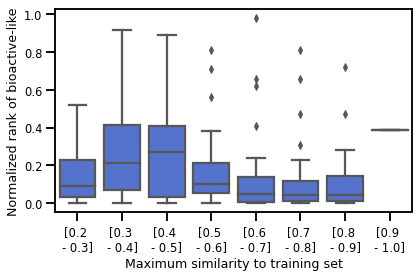

-0.089


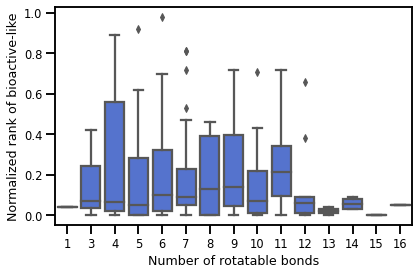

-0.254


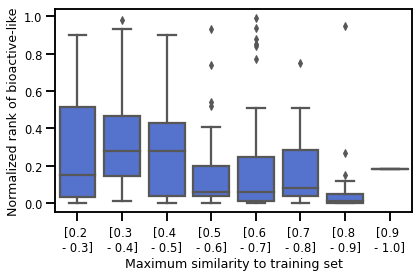

-0.137


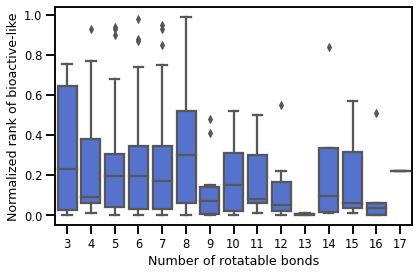

-0.313


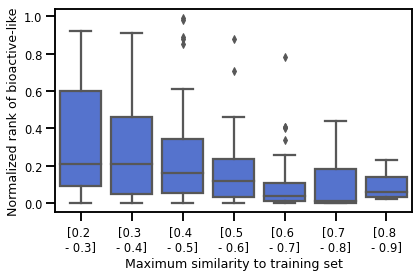

0.082


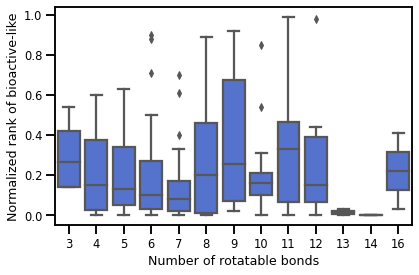

-0.303


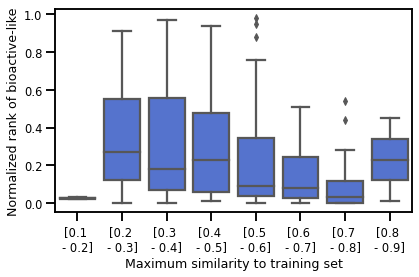

0.002


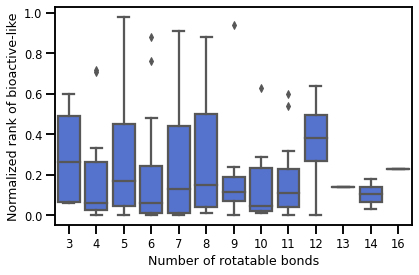

-0.292


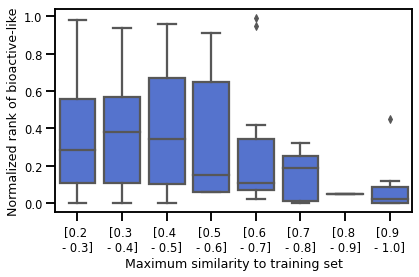

-0.047


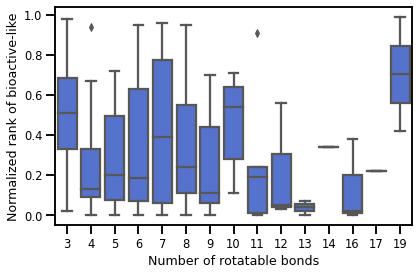

-0.267


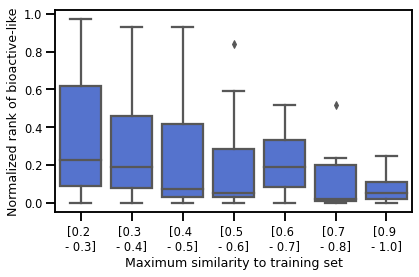

-0.185


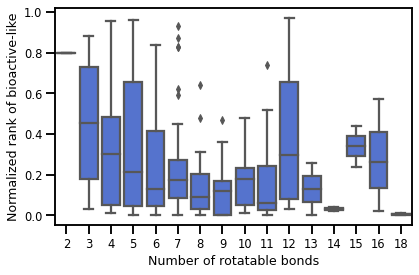

In [48]:
from scipy.stats import pearsonr, spearmanr
for split in ['random', 'scaffold', 'protein'] :
    for iteration in range(2) :
        mol_results_path = f'results/{split}_split_{iteration}_pdbbind/mol_results.p'
        with open(mol_results_path, 'rb') as f :
            mol_results = pickle.load(f)
            
        ranks, n_rot_bonds, max_training_sims = get_ranks(mol_results)
        pearson_coeff = np.around(pearsonr(max_training_sims, ranks['model'])[0], 
                            3)
        print(pearson_coeff)
        df = similarity_bins(max_training_sims, ranks['model'])
        xlabel = 'Maximum similarity to training set'
        ylabel = 'Normalized rank of bioactive-like'
        df.columns = [xlabel, ylabel]
        with sns.plotting_context('talk', font_scale=0.7) :
            boxplot = sns.boxplot(data=df, 
                        x=xlabel, 
                        y=ylabel,
                        color='royalblue')
            rename_similarity_label(boxplot)
            plt.tight_layout()
            plt.show()
            plt.close()
            
            xlabel = 'Number of rotatable bonds'
            df = pd.DataFrame(zip(n_rot_bonds, ranks['model']), 
                          columns=[xlabel, ylabel])
            sns.boxplot(data=df, 
                        x=xlabel, 
                        y=ylabel,
                        color='royalblue')
            pearson_coeff = np.around(pearsonr(df[xlabel].values, df[ylabel].values)[0], 
                            3)
            print(pearson_coeff)
            plt.tight_layout()
            plt.show()
            plt.close()

In [22]:
df = pd.DataFrame(columns=['split', 'iteration', 'ranker', 'median', 'fraction'])
for split in ['random', 'scaffold', 'protein'] :
    for iteration in range(5) :
        mol_results_path = f'results/{split}_split_{iteration}_pdbbind/mol_results.p'
        with open(mol_results_path, 'rb') as f :
            mol_results = pickle.load(f)
            
        ranks, n_rot_bonds, max_training_sims = get_ranks(mol_results)
        for ranker, rs in ranks.items() :
            median = np.median(rs)
            fraction = len([r for r in rs if r == 0]) / len(rs)
            series = pd.Series({'split' : split,
                               'iteration' : iteration,
                                'ranker' : ranker,
                               'median' : median,
                               'fraction' : fraction})
            df = df.append(series, ignore_index=True)

In [25]:
def custom_ranker_order(series) :
    d = {'BioSchNet' : 0,
         'CCDC' : 1,
         'UFF energy' : 2,
         'Random' : 3}
    return [d[s] for s in series]

In [27]:
def custom_agg(series) :
    result = ''
    
    mean = series.mean()
    if not np.isnan(mean) :
        result = result + str(mean.round(2))
        
    std = series.std().round(2)
    if not np.isnan(std) :
        result = result + ' ± ' + str(std.round(2))
    
    if result == '' :
        result = 'NA'
    return result

In [30]:
ratiolabel = 'Fraction of molecules with bioactive-like ranked first'
ranklabel = 'Median normalized rank of first bioactive-like conformation'
new_data = df.rename({'fraction' : ratiolabel,
                      'median' : ranklabel}, axis=1)
new_data['Ranker'] = new_data['ranker'].replace({'model' : 'BioSchNet',
                                                 'energy' : 'UFF energy',
                                                 'random' : 'Random',
                                                 'ccdc' : 'CCDC'})
new_data = new_data.sort_values(by='Ranker', key=lambda s: custom_ranker_order(s), kind='stable')
grouped_data = new_data.groupby(['split', 'Ranker'], sort=False).agg({ratiolabel : custom_agg,
                                                                      ranklabel : custom_agg})
grouped_data = grouped_data.unstack(1)
grouped_data.index.name = 'Split'
grouped_data.columns.names = [None, 'Ranker']
grouped_data = grouped_data.rename({name : name.capitalize() for name in grouped_data.index})

In [31]:
grouped_data

Fraction of molecules with bioactive-like ranked first               \
Ranker                                                BioSchNet         CCDC   
Split                                                                          
Random                                          0.13 ± 0.04      0.02 ± 0.01   
Scaffold                                        0.13 ± 0.03      0.03 ± 0.01   
Protein                                         0.07 ± 0.03      0.03 ± 0.01   

                                    \
Ranker     UFF energy       Random   
Split                                
Random    0.05 ± 0.02  0.03 ± 0.01   
Scaffold  0.04 ± 0.02  0.03 ± 0.02   
Protein   0.04 ± 0.01  0.03 ± 0.01   

         Median normalized rank of first bioactive-like conformation  \
Ranker                                                     BioSchNet   
Split                                                                  
Random                                          0.11 ± 0.02            
Scaffold                                        0.11 ± 0.02            
Protein                                          0.2 ± 0.03            

                                                 
Ranker           CCDC   UFF energy       Random  
Split                                            
Random    0.33 ± 0.02  0.24 ± 0.02  0.27 ± 0.01  
Scaffold  0.31 ± 0.02  0.23 ± 0.02  0.28 ± 0.03  
Protein   0.31 ± 0.04  0.26 ± 0.02  0.26 ± 0.03

In [8]:
# look at the bioactive conformation identification performance of highly flexible molecules



conf_results_path = 'results/random_split_0_pdbbind/conf_results.p'
with open(conf_results_path, 'rb') as f :
    conf_results = pickle.load(f)

In [10]:
rankers_ranks = defaultdict(list)
for smiles in mol_results :
    result = mol_results[smiles]
    if ('normalized_first_bioactive_like_rank' in result) :
        n_actives = result['n_actives']
        n_generated = result['n_generated']
        active_ratio = n_actives / n_generated
        if active_ratio < 0.05 :
            rn = result['normalized_first_bioactive_like_rank']
            for ranker in rn :
                rankers_ranks[ranker].append(rn[ranker])

In [14]:
for ranker in rankers_ranks :
    normalized_first_bioactive_like_ranks = rankers_ranks[ranker]
    fraction_top_bioactive_like = len([r for r in normalized_first_bioactive_like_ranks if r == 0]) / len(normalized_first_bioactive_like_ranks)
    print(fraction_top_bioactive_like)

    print(np.median(normalized_first_bioactive_like_ranks))

0.16774193548387098
0.09
0.03870967741935484
0.32
0.03870967741935484
0.26
0.03870967741935484
0.27
